In [16]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
import os

#### Formattage des données pour notre modèle

In [5]:
df_com = gpd.read_file("./data_test.geojson")

In [7]:
df_com.head()

,insee_com,postal_code,nom_comm,nom_dept,nom_region,statut,z_moyen,superficie,population,id_geofla,...,code_reg,CHAT_2017,CHIEN_2017,CHAT_2018,CHIEN_2018,CHAT_2019,CHIEN_2019,CHAT_2020,CHIEN_2020,geometry
0,63402,63550,SAINT-VICTOR-MONTVIANEIX,[PUY-DE-DOME],[AUVERGNE],[Commune simple],750,4508,0.3,2003,...,83,36,177,40,180,0,3,36,193,"MULTIPOLYGON (((3.61160 45.91626, 3.59725 45.9..."
1,64012,64130,AINHARP,[PYRENEES-ATLANTIQUES],[AQUITAINE],[Commune simple],232,1431,0.1,3178,...,72,3,13,5,16,0,17,4,20,"MULTIPOLYGON (((-0.92367 43.22848, -0.93207 43..."
2,26027,26150,BARSAC,[DROME],[RHONE-ALPES],[Commune simple],606,1582,0.2,8215,...,82,200,475,220,454,229,420,267,487,"MULTIPOLYGON (((5.32560 44.70649, 5.32153 44.7..."
3,2A108,20126,EVISA,[CORSE-DU-SUD],[CORSE],[Commune simple],1160,6720,0.2,1332,...,94,9,25,7,28,0,0,8,25,"MULTIPOLYGON (((8.81320 42.23916, 8.80954 42.2..."
4,42205,42940,SAINT-BONNET-LE-COURREAU,[LOIRE],[RHONE-ALPES],[Commune simple],992,5036,0.7,7682,...,82,18,110,26,122,0,1,33,128,"MULTIPOLYGON (((3.86867 45.61324, 3.86092 45.6..."


In [21]:
fichiers = [
    "actif_15_64.xlsx",
    "concentration_emploi.xlsx",
    "densite_pop.xlsx",
    "menage_10ans_plus.xlsx",
    "nb_hlm.xlsx",
    "nb_menage_couple.xlsx",
    "part_menage_voiture.xlsx",
    "part_rp_proprio_65_plus.xlsx",
    "pop_65_plus.xlsx",
    "tx_nat.xlsx"
]

chemin = "data_variable/"
dataframes = {}

def charger_fichier(fichier):
    nom_colonne = fichier.split(".")[0]
    print(nom_colonne)
    df = pd.read_excel(os.path.join(chemin, fichier), header=4)
    dataframes[nom_colonne] = df

with ProcessPoolExecutor() as executor:
    executor.map(charger_fichier, fichiers)

In [20]:
dataframes

{}

In [49]:
for nom_colonne, df in dataframes.items():
    dataframes[nom_colonne] = df.loc[df['an'] == 2020]
    dataframes[nom_colonne] = dataframes[nom_colonne].drop(columns=["an", "libgeo"])

In [50]:
df_variable = dataframes['actif_15_64'] 

for nom_colonne, df in dataframes.items():
    if nom_colonne != 'actif_15_64': 
        df_variable = pd.merge(df_variable, df, on='codgeo', how='outer')

In [51]:
df_variable = df_variable.drop(columns=["tx_nat"])
df_variable = df_variable.dropna()
df = pd.merge(df_insee, df_variable, left_on= "code_commune_insee", right_on = "codgeo", how = "left")
df = df.dropna(subset=['code_commune_insee'])
df = df.drop(['nom_comm','code_commune_insee'], axis=1)
df = df[df['CHIEN_2020'] != 0]
df = df.set_index(['nom_de_la_commune', 'codgeo'])
df.replace("N/A - résultat non disponible", np.nan, inplace=True)
df = df.dropna()

In [53]:
data_chien = pd.read_excel('data.xlsx', index_col='nom_comm')
data_chien = data_chien[['CHIEN_2017', 'CHIEN_2018', 'CHIEN_2019', 'CHIEN_2020']]
data_chien = data_chien.transpose()
data_chien

nom_comm,SAINT-VICTOR-MONTVIANEIX,AINHARP,BARSAC,EVISA,SAINT-BONNET-LE-COURREAU,MANOU,COLLONGES-AU-MONT-D'OR,SAINT-MARTIN-SUR-COJEUL,VIDAI,SAINT-GUYOMARD,...,ROSUREUX,LA BREE-LES-BAINS,SAINT-FELIX-DE-L'HERAS,BEFFIA,LACHAUSSEE-DU-BOIS-D'ECU,COURDEMANCHE,HELSTROFF,SAINT-JUSTIN,PISANY,SADIRAC
CHIEN_2017,177,13,475,25,110,256,386,41,48,281,...,55,0,32,16,43,292,0,0,144,887
CHIEN_2018,180,16,454,28,122,294,386,42,43,298,...,55,0,28,21,47,299,0,0,135,850
CHIEN_2019,186,18,470,26,125,328,394,45,43,308,...,51,92,31,23,46,300,0,0,137,819
CHIEN_2020,193,20,487,25,128,363,403,48,44,318,...,48,184,34,25,46,302,0,0,140,789


#### Distribution de chien pour les 4 années consécutives

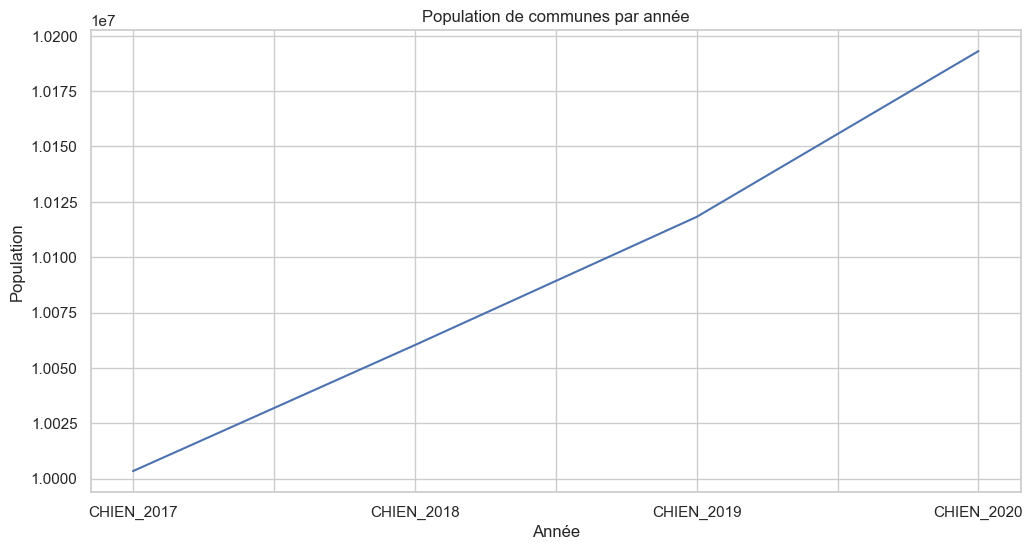

In [54]:
data_chien['Somme'] = data_chien.sum(axis=1)
data_chien['Somme'].plot(figsize=(12, 6))
plt.title('Population de communes par année')
plt.xlabel('Année')
plt.ylabel('Population')
plt.show()

###### **Interprétation** : Distribution linéaire entre les année

#### Distribution négative des données CHIEN_2020

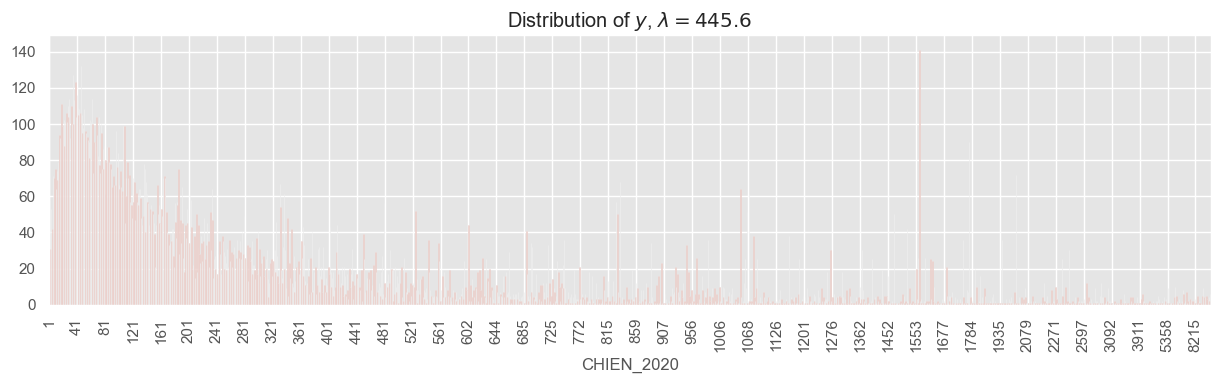

In [72]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

m = df['CHIEN_2020'].mean()
s = df['CHIEN_2020'].value_counts().sort_index()
ax = s.plot(kind='bar', figsize=(15, 3.5), title=rf'Distribution of $y$, $\lambda={m:.1f}$')
_ = ax.xaxis.set_major_locator(plt.MaxNLocator(50))

###### Non prise en compte de la gestion des valeurs abberantes pour la régression, à tester 

#### Graphique sur la distribution de chaque variable

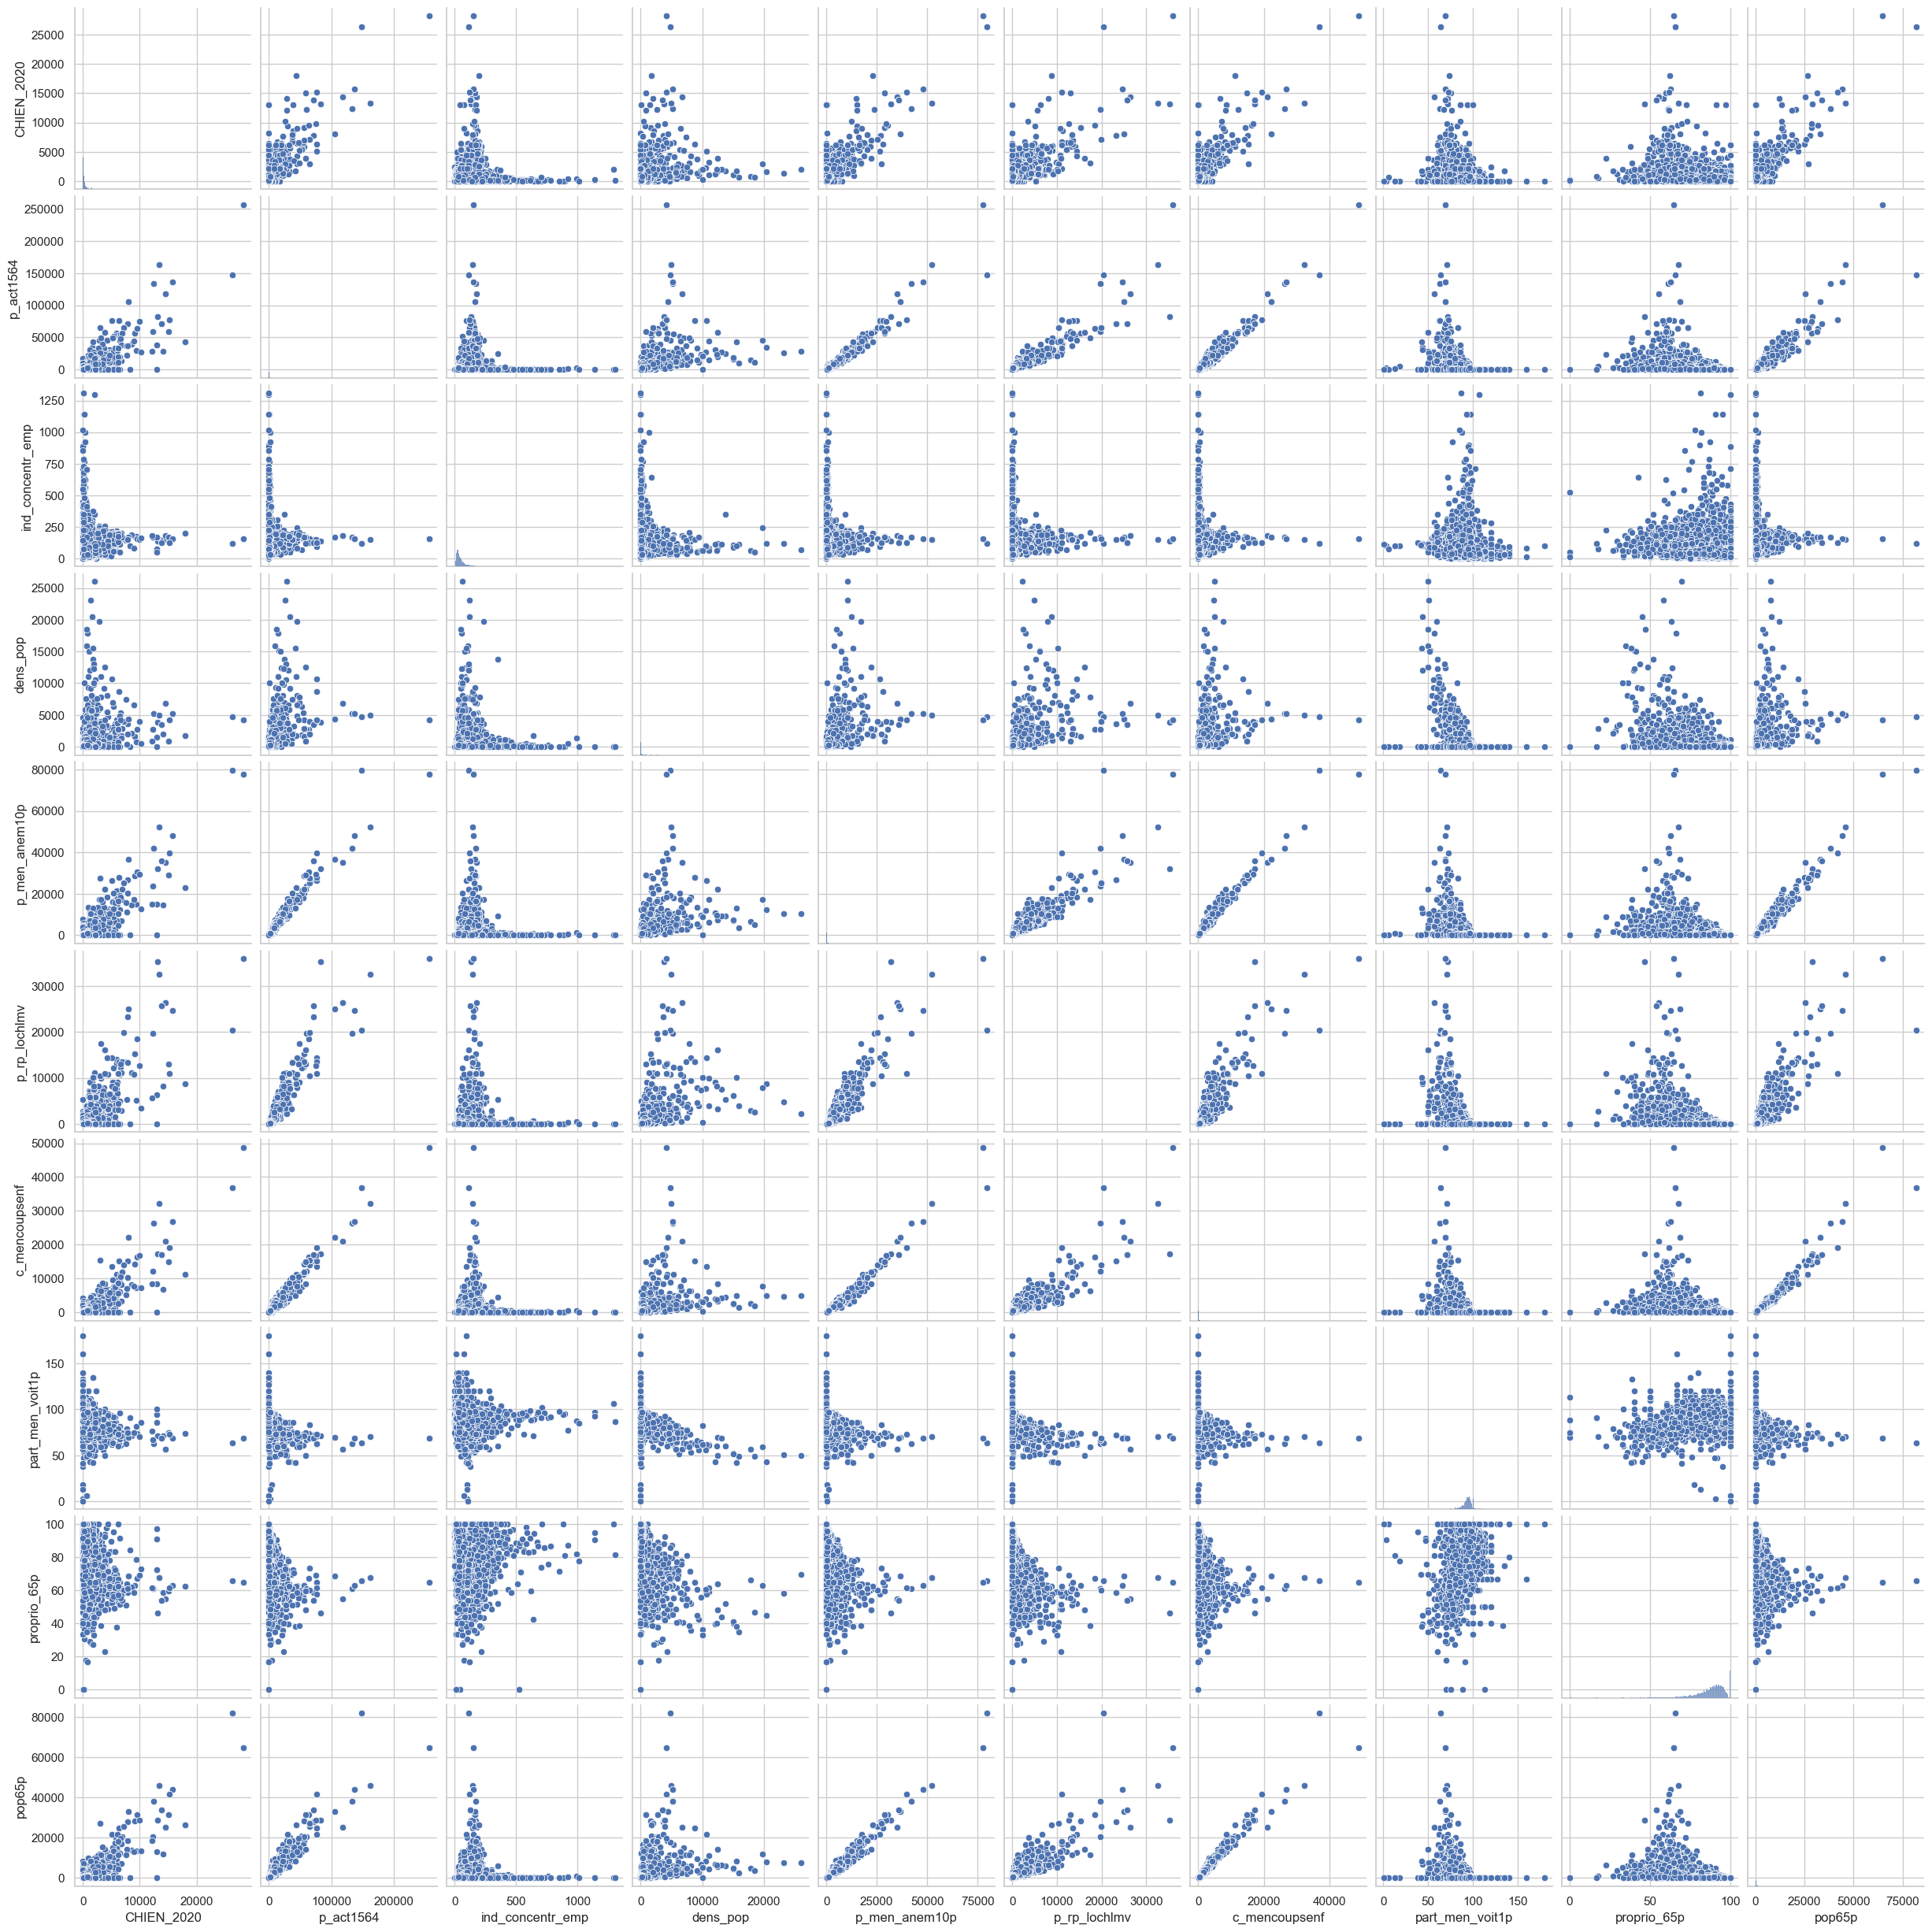

In [56]:
data = df[df.columns.tolist()]

# Créer un nuage de points avec seaborn
sns.set(style="whitegrid")  # Utilisez un fond blanc avec des grilles

# Utilisez la fonction pairplot pour créer un nuage de points
sns.pairplot(data)
plt.show()

#### Calcul des corrélation pour chaque variable

In [57]:
correlation_matrix = df.corr()

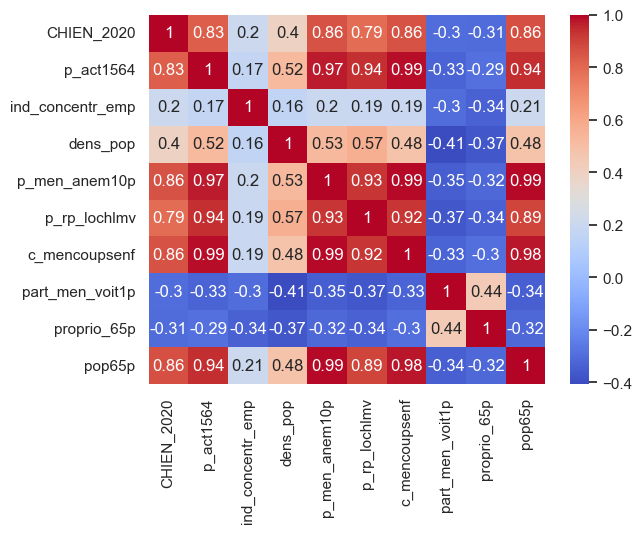

In [58]:
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()


In [59]:
correlations_with_y = correlation_matrix['CHIEN_2020'][(correlation_matrix['CHIEN_2020'] > 0.8) | (correlation_matrix['CHIEN_2020'] < -0.8)]
correlations_with_y.index.tolist()

['CHIEN_2020', 'p_act1564', 'p_men_anem10p', 'c_mencoupsenf', 'pop65p']

###### **Interprétation** : 4 variables indépendantes sont fortement corrélées à la variable dépendante "CHIEN_2020"

#### Test de multicolinéarité entre les variables indépendantes

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['p_act1564', 'pop65p']]

vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

     feature       VIF
0  p_act1564  8.971085
1     pop65p  8.971085


###### **Interprétation** : On a un VIF inférieur à 10, on considère une multicolinéarité acceptable entre les variables dépendantes

#### Régression multiple avec deux variables indépendantes

In [61]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

y = df_standardized['CHIEN_2020']
X = df_standardized[['p_act1564', 'pop65p']]

X = sm.add_constant(X)

model = sm.OLS(y, X)

result = model.fit(cov_type='HC3')

print(result.summary())


                            OLS Regression Results                            
Dep. Variable:             CHIEN_2020   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1412.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:14:30   Log-Likelihood:                -19263.
No. Observations:               26418   AIC:                         3.853e+04
Df Residuals:                   26415   BIC:                         3.856e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.281e-18      0.003  -1.71e-15      1.0

###### **Interprétation** : on a un coefficient de détermination (r²) de **75%** ce qui est correcte

#### Calcul du MSE (erreur quadratique moyenne)

In [62]:
y_pred = result.predict(X)

mse = np.mean((y - y_pred)**2)

print("Mean Squared Error (MSE) :", mse)

Mean Squared Error (MSE) : 0.2516815727339805


###### **Interprétation** : MSE est très faible, bon point